# Chapter 5 Exercises

In [1]:
import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pydataset import data
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from numpy.random import seed

%load_ext rpy2.ipython

## Conceptual

### 2.h)
We will now investigate numerically the probability that a bootstrap sample of size $n = 100$ **contains** the $j$th observation. Here $j = 4$. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.

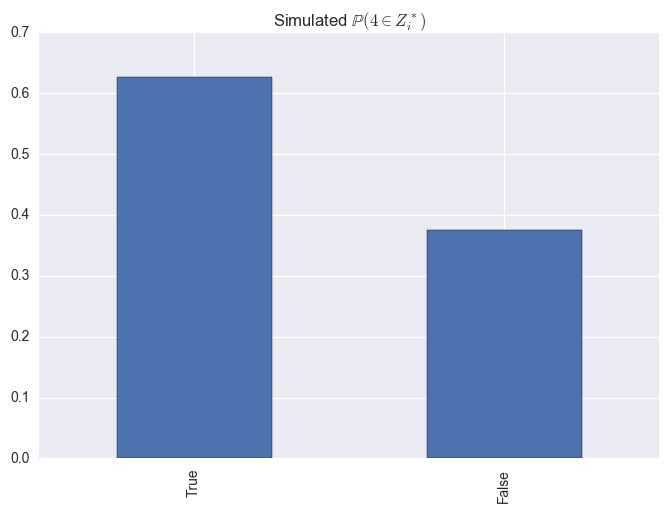

In [2]:
ntimes = 10000
store = pd.Series([4 in choice(range(1,101), size=100, replace=True) for _ in range(ntimes)])
store_freq = pd.value_counts(store, normalize=True)
store_freq.plot(kind="bar")
plt.title(r"Simulated $\mathbb{P}(4 \in Z_i^*)$")
plt.show()

In [3]:
print("P(4 in Sample [Simulation])  = {:.4f}".format(store.mean()))
print("P(4 in Sample [Theoretical]) = {:.4f}".format(1 - (1 - 1/100)**100))

P(4 in Sample [Simulation])  = 0.6256
P(4 in Sample [Theoretical]) = 0.6340


**Comment on the results obtained.**

The simulation yielded a pretty similar result as the theoretical. That is
$$
    \mathbb{P}(i \in Z_n^*) = 1 - \left(1 - \frac{1}{n}\right)^n
$$


Evidently, 
$$
    \mathbb{P}(i \in Z_n^*) \xrightarrow[n\rightarrow\infty]{} 1 - e^{-1}
$$

## Applied

### 5.
In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [13]:
%R -o default library(ISLR); default=Default;
default.default = [1 if dflt == "Yes" else 0 for dflt in default.default]
default.student = [1 if stdnt == "Yes" else 0 for stdnt in default.student]

#### 5.a)
Fit a logistic regression that uses `income` and `balance` to predict `default` *(The wrong way to do it)*

In [3]:
X = default[["income", "balance"]]
y = default.default

lrmod = LogisticRegression()
lrmod.fit(X, y)

(lrmod.predict(X) == y).mean()

0.96640000000000004

Fitting the logistic regression and computing the Overall Error Rate on the training dataset, we get 96% accuracy. This is not the way to do it.

#### 5.b)
Using the validation set approach, estimate the test error for this model.
1. Split the sample set into a training set and a validation set.
2. Fit a multiple logistic regression model using only the training observations.
3. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassiﬁed.

In [27]:
seed(1643)

### 1)
train_default, test_default = train_test_split(default, test_size=0.3)

### 2)
X = train_default[["income", "balance"]]
y = train_default.default
lrmod = LogisticRegression()
lrmod.fit(X, y)

### 3)
oer = 1 - np.mean(lrmod.predict(test_default[["income", "balance"]]) == test_default.default)
print("{:.4f}".format(oer))

0.0310


#### 5.c)
Repeat the process in **(b)** three times, using three diﬀerent splits of the observations into a training set and a validation set. Comment on the results obtained.

In [5]:
X = default[["income", "balance"]]
y = default.default

n_folds = 3
kf = KFold(len(X), n_folds=n_folds)

mean_error = 0
for train, test in kf:
    X_train, X_test = X.iloc[train, :], X.iloc[test, :]
    y_train, y_test = y.values[train], y.values[test]
    
    lrmod_kf = LogisticRegression()
    lrmod_kf.fit(X_train, y_train)
    
    error_kf = 1 - np.mean(lrmod.predict(X_test) == y_test)
    
    mean_error += error_kf

mean_error /= n_folds; mean_error

0.033799840691927575

The overall error rate with a 3-fold C.V. was 9% bigger than with the validation set approach. Recalling the properties of the k-fold C.V., we know that this estimation is less biased than the Validation set approach.

**5.d)**

Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [28]:
seed(1643)
X = default.drop("default", axis=1)
y = default.default

X_train, X_test = train_test_split(X, test_size=0.3)
y_train, y_test = train_test_split(y, test_size=0.3)

lrmod = LogisticRegression()
lrmod.fit(X_train, y_train)

oer = 1 - np.mean(lrmod.predict(X_test) == y_test)
print("{:.4f}".format(oer))

0.0373


Including a dummy variable for student made the *Overall Error Rate* (oer) to be less accurate than without it. This could be caused by the bias of the validation set approach

### 6.
We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coeﬃcients in two diﬀerent ways: 
1. using the bootstrap, and 
2. using the standard formula for computing the standard errors in the glm() function.

**6.a)**

Using the `summary()` and `glm()` functions, determine the estimated standard errors for the coeﬃcients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.

In [172]:
seed(1643)
X = default[["income", "balance"]]; X = sm.add_constant(X)
y = default.default

main_lrmod = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(main_lrmod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Tue, 27 Sep 2016   Deviance:                       1579.0
Time:                        09:04:55   Pearson chi2:                 6.95e+03
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000       -12.393   -10.688
income      2.081e-05   4.99e-06      4.174      0.0

**6.b)**
Write a function, `boot_fn()`, that takes as input the `Default` data set as well as an index of the observations, and that outputs the coeﬃcient estimates for income and balance in the multiple logistic regression model.

In [104]:
def boot_fn(default, index):
    X = default[["income", "balance"]].iloc[index, :]; X = sm.add_constant(X)
    y = default.default[index]

    lrmod = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    return lrmod.params[["income", "balance"]]

**6.c)**

Use the `boot()` function together with your `boot.fn()` function to estimate the standard errors of the logistic regression coeﬃcients for income and balance.

In [134]:
seed(100)

nsamp = 1000
income_boot = np.repeat(np.nan, nsamp)
balance_boot = np.repeat(np.nan, nsamp)
for i in range(nsamp):
    boot_data = resample(default.drop("student", axis=1))
    X_boot = boot_data[["income", "balance"]]; X_boot = sm.add_constant(X_boot)
    y_boot = boot_data.default
    
    lrmod_boot = sm.GLM(y_boot, X_boot, family=sm.families.Binomial()).fit()
    income_est, balance_est = lrmod_boot.params[["income", "balance"]]
    
    income_boot[i] = income_est
    balance_boot[i] = balance_est

The estandard error for the bootstrap estimates is given by:
$$
    SE_{B}(\hat{\alpha}) = \sqrt{\frac{1}{B-1}\sum_{r=1}^B \left( \hat{\alpha}^{*r} - \frac{1}{B}\sum_{r'=1}^B \hat{\alpha}^{*r'}\right)^2}
$$

//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


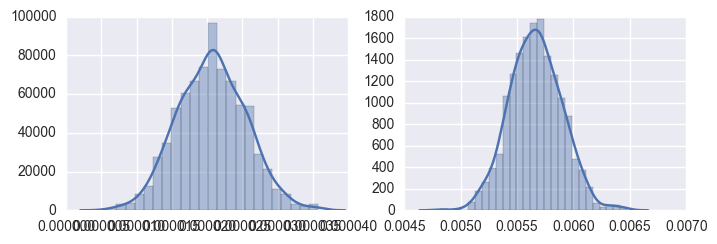

In [142]:
fig = plt.figure()
fig.add_subplot(221)
sns.distplot(income_boot)
fig.add_subplot(222)
sns.distplot(balance_boot)
plt.show()

In [176]:
def standard_error_bootstrap(s_erros):
    return np.sqrt(sum((s_erros  - np.mean(s_erros))**2) / (len(s_erros) - 1))

income_boot_se = standard_error_bootstrap(income_boot)
balance_boot_se = standard_error_bootstrap(balance_boot)

In [224]:
print("'balance' bootstrap standard error: {:>13e}".format(balance_boot_se))
print("'balance' theoretical standard error: {:e}".format(main_lrmod.bse["balance"]))
print()
print("'income' bootstrap standard error: {:>14e}".format(income_boot_se))
print("'income' theoretical standard error: {:e}".format(main_lrmod.bse["income"]))

'balance' bootstrap standard error:  2.314109e-04
'balance' theoretical standard error: 2.273814e-04

'income' bootstrap standard error:   4.794017e-06
'income' theoretical standard error: 4.985245e-06


**6.d)**
Comment on the estimated standard errors obtained using the `glm()` function and using your bootstrap function.

The estandard error predicted by the model and the bootstrap estandard errors approximate each other for each of the estimated parameters

### 7

We will compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classiﬁcation problems, the LOOCV error is given in (5.4).

In [2]:
%R -o weekly library(ISLR); weekly=Weekly;

**7.a)**

Fit a logistic regression model that predicts Direction using Lag1 and Lag2.

In [3]:
X = weekly[["Lag1", "Lag2"]]
y = weekly.Direction
dir_logr = LogisticRegression()
dir_logr.fit(X, y)
dir_logr.score(X,y)

0.55555555555555558

**7.b)**

Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but the ﬁrst observation.

In [4]:
dir_logr = LogisticRegression()
dir_logr.fit(X.iloc[1:,:], y[1:])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**7.c)**

Use the model from (b) to predict the direction of the ﬁrst observation. You can do this by predicting that the ﬁrst observation will go up if $\mathbb{P}(\text{Direction}=\text{"Up"} |\text{ Lag1}, \text{ Lag2}) > 0.5$. Was this observation correctly classiﬁed?

In [5]:
dir_logr.predict([X.values[1]]) == y[1]

array([False], dtype=bool)

The observation was **NOT** correctly classified

**7.d)** 

Write a for loop from i = 1 to i = n, where n is the number of observations in the data set, that performs each of the following steps:
1. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.
2. Compute the posterior probability of the market moving up for the ith observation.
3. Use the posterior probability for the ith observation in order to predict whether or not the market moves up.
4. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

In [28]:
n = len(X)
loocv_folds = KFold(n, n_folds=n)
total_assertions = 0

for fold in loocv_folds:
    train_indices, test_index = fold
    X_train, X_test = X.values[train_indices,:], X.values[test_index,:]
    y_train, y_test = y.values[train_indices], y.values[test_index]
    
    loocv_log_reg = LogisticRegression()
    loocv_log_reg.fit(X_train, y_train)
    
    # Test whether the datum is correctly predicted
    pred = (loocv_log_reg.predict(X_test) == y_test)*1
    total_assertions += pred

**7.e)**

Take the average of the n numbers obtained in (d)4. in order to obtain the LOOCV estimate for the test error. Comment on the results.

In [29]:
total_assertions / n

array([ 0.55004591])

The results show that, under the LOOCV test, the test sample error was about 55%

### 8
We will now perform cross-validation on a simulated data set.

**8.a)**

Generate a simulated data set as follows:

```
> set.seed (1)

> y=rnorm (100)

> x=rnorm (100)

> y=x-2*x^2+ rnorm (100)
```
In this data set, what is $n$ and what is $p$? Write out the model used to generate the data in equation form.

$n=100$

In [66]:
%R -o x,y set.seed(1); y = rnorm(100); x = rnorm(100); y=x-2*x+rnorm(100);

**8.b)**

Create a scatterplot of X against Y . Comment on what you ﬁnd

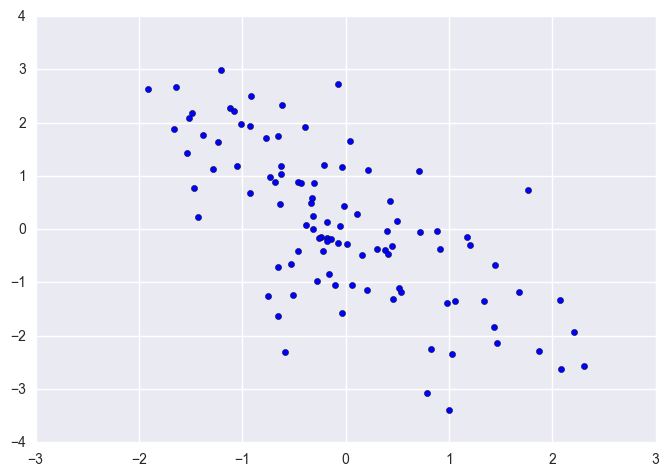

In [146]:
plt.scatter(x,y)
plt.show()

$y$ is negatively correlated against $x$

**8.c)**

Set a random seed, and then compute the LOOCV errors that result from ﬁtting the following four models using least squares:

1. $Y = \beta_0 + \beta_1X + \epsilon$
2. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
3. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 \epsilon$
4. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 \beta_4X^4 + \epsilon$

In [123]:
n = len(x)
kfolds = KFold(n=n, n_folds=n)

# Store the linear models with different degrees
lr_models = {1:[],
             2:[],
             3:[],
             4:[]}

# LOOCV train:
for fold in kfolds:
    train_indices, test_index = fold
    x_train, x_test = x[train_indices], x[test_index]
    y_train, y_test = y[train_indices], y[test_index]
    
    # Fit training data for each degree
    for deg in range(1, 5):
        betas = np.polyfit(x_train, y_train, deg=deg)
        y_hat = y_hat_compute(betas, x_test, deg)
        # Appending MSE for each test
        lr_models[deg].append(((y_hat - y_test)**2 / len(y_test))[0])
        
lr_models = pd.DataFrame(lr_models)

In [127]:
print("LOOCV Estimate")
lr_models.apply(np.mean)

LOOCV Estimate


1    1.096903
2    1.086596
3    1.102585
4    1.114772
dtype: float64

**8.d)** 

Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?

The results will be the same, there is no randomness involved in LOOCV

**8.e)**

Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

The model $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$ had the lowest LOOCV. It was expected since the underlying "real" model was given by $y= 0 + x-2x^2 +\epsilon$

**8.f)**

Comment on the statistical signiﬁcance of the coeﬃcient estimates that results from ﬁtting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

In [141]:
for i in range(1,6):
    print("Deg:{}".format(i))
    print(*np.round(np.polyfit(x, y, deg=i),3)[::-1], end="\n\n")

Deg:1
0.028 -1.053

Deg:2
-0.095 -1.1 0.133

Deg:3
-0.099 -1.044 0.147 -0.025

Deg:4
-0.139 -1.09 0.272 0.007 -0.038

Deg:5
-0.135 -1.17 0.227 0.107 -0.018 -0.023



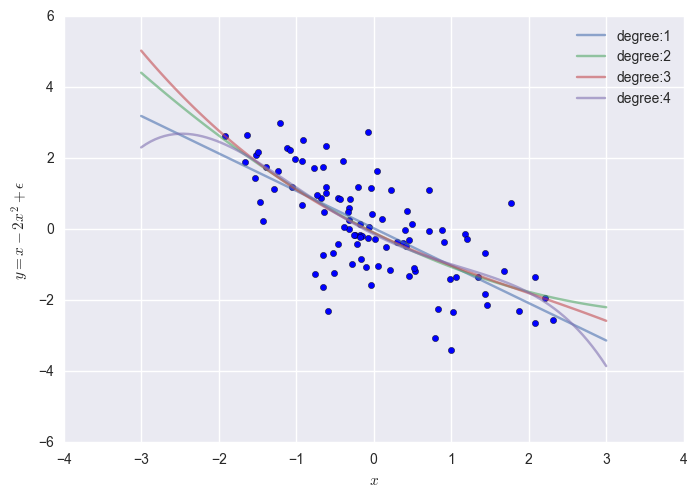

In [143]:
def y_hat_compute(betas, x, degree):
    """Betas for linear regression with
    highest degrees first"""
    y_hat = 0
    for n, beta in enumerate(betas):
        y_hat += np.power(x, degree - n) * beta
        
    return y_hat

# Fitting various degrees of a polynomial regression
plt.scatter(x, y)

for deg in range(1, 5):
    betas = np.polyfit(x, y, deg=deg)
    # domain to plot the fit
    fit = np.linspace(-3, 3, 100)
    # to be a numpy array with the fitted values
    fitted = y_hat_compute(betas, fit, deg)        
    plt.plot(fit, fitted, label = "degree:{}".format(deg), alpha=0.6)    
    
plt.xlabel(r"$x$")
plt.ylabel(r"$y=x-2x^2 +\epsilon$")
plt.legend()
plt.show()

Grafically, we can see that the coefficients adjust to the scatterplot. Yet, neither model correctly adjusted the real coefficients.

### 9

We will now consider the Boston housing data set, from the MASS library.

**9.a)**

Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat\mu$

**9.b)**

Provide an estimate of the standard error of $\hat\mu$. Interpret this result. 

*Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.*

Now estimate the standard error of $\hat\mu$ using the bootstrap. How does this compare to your answer from (b)?

Based on your bootstrap estimate from (c), provide a 95% conﬁdence interval for the mean of medv. Compare it to the results obtained using t.test(Boston$medv). 

Hint: You can approximate a 95\% conﬁdence interval using the formula $[\hat\mu − 2SE(\hat\mu), \  \hat\mu+ 2SE(\hat\mu)]$

Based on this data set, provide an estimate, $\hat\mu_{med}$ , for the median value of medv in the population.

We now would like to estimate the standard error of $\hat\mu_{med}$ . Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your ﬁndings

Based on this data set, provide an estimate for the tenth per- centile of medv in Boston suburbs. Call this quantity $\hat\mu_{0.1}$. (You can use the quantile() function.)

Use the bootstrap to estimate the standard error of $\hat\mu_{0.1}$. Comment on your ﬁndings.